## Setup

In [3]:
pwd

'/home/jake/Projects/mila/6759/cnn-downscaling/src'

### Dependencies

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns

import torch
import torch.nn.functional as F

from training.data import WeatherBenchSuperresolutionDataModule
from training.models import LitSuperresolutionModelWrapper

In [6]:
plt.style.use('seaborn-pastel')
sns.set_style("ticks")

### Arguments

In [7]:
best_ckpt = "/home/jake/Projects/mila/6759/cnn-downscaling/logs/cnn/1uyqum0l/checkpoints/best_val_loss_epoch=0057.ckpt"

In [8]:
DATA_DIR = "../data/processed/temp/"
COARSE_SUB_DIR = "5625/temp_5625_processed.zarr"  # 5.625 degrees
FINE_SUB_DIR = "1406/temp_1406_processed.zarr"  # 1.402 degrees

### Data

In [9]:
data_module = WeatherBenchSuperresolutionDataModule(
    coarse_dir = os.path.join(DATA_DIR, COARSE_SUB_DIR),
    fine_dir = os.path.join(DATA_DIR, FINE_SUB_DIR),
    batch_size = 2922  # length of validation set
)

data_module.setup(stage=None)

val_dataloader = data_module.val_dataloader()
coarse_validation, fine_validation = iter(val_dataloader).next()

del val_dataloader

### Best Checkpoint

In [10]:
model = LitSuperresolutionModelWrapper.load_from_checkpoint(best_ckpt)

model.eval()

LitSuperresolutionModelWrapper(
  (model): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(5, 21, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): Conv2d(21, 55, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): ReLU()
    (6): Conv2d(55, 144, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14400, out_features=2592, bias=True)
    (10): Linear(in_features=2592, out_features=1344, bias=True)
    (11): Linear(in_features=1344, out_features=4096, bias=True)
    (12): Unflatten(dim=1, unflattened_size=(64, 64))
  )
  (loss): MSELoss()
)

### Generate Validation Set Predictions

In [11]:
preds_validation = model(coarse_validation)
preds_validation.shape

torch.Size([2922, 64, 64])

## Evaluation Metrics

In [12]:
torch. set_grad_enabled(False);

#### MSE

In [13]:
mse = F.mse_loss(preds_validation, fine_validation)
mse  # aligns with https://wandb.ai/6759-proj/cnn/runs/1uyqum0l

tensor(1.8316)

In [14]:
daily_mses = torch.mean((preds_validation - fine_validation)**2, dim=(1,2))
torch.mean(daily_mses)

tensor(1.8316)

#### Correlation

In [15]:
pred_demeaned = (preds_validation - preds_validation.mean(axis=(1,2), keepdims=True))
true_demeaned = (fine_validation - fine_validation.mean(axis=(1,2), keepdims=True))

daily_corrs = \
    torch.sum(pred_demeaned*true_demeaned, axis=(1,2)) / \
    (torch.sqrt(torch.sum(pred_demeaned ** 2, axis=(1,2))) * torch.sqrt(torch.sum(true_demeaned ** 2, axis=(1,2))))

del pred_demeaned, true_demeaned

print(daily_corrs.min(), daily_corrs.mean(), daily_corrs.max())

tensor(0.9894) tensor(0.9960) tensor(0.9984)


#### Bias

In [16]:
preds_p02 = torch.quantile(preds_validation.reshape(preds_validation.shape[0], -1), dim=1, q=.02)
preds_p98 = torch.quantile(preds_validation.reshape(preds_validation.shape[0], -1), dim=1, q=.98)

fine_p02 = torch.quantile(fine_validation.reshape(preds_validation.shape[0], -1), dim=1, q=.02)
fine_p98 = torch.quantile(fine_validation.reshape(preds_validation.shape[0], -1), dim=1, q=.98)

In [17]:
daily_biases_mean =  preds_validation.mean(axis=(1,2)) - fine_validation.mean(axis=(1,2))
daily_biases_p02 = preds_p02 - fine_p02
daily_biases_p98 = preds_p98 - fine_p98

#### Stability

In [18]:
preds_std = torch.std(preds_validation, dim=(1,2))
fine_std = torch.std(fine_validation, dim=(1,2))

In [19]:
daily_stability = preds_std / fine_std

## Evaluation Analysis

### Aggregate Results

In [20]:
train_dates, val_dates, test_dates = data_module.split_date_ranges

In [21]:
eval_metrics = pd.DataFrame(
    {
        'mse' : daily_mses,
        'corr' : daily_corrs,
        'bias_p02' : daily_biases_p02,
        'bias_mean' : daily_biases_mean,
        'bias_p98' : daily_biases_p98,
        'stability' : daily_stability,
    },
    index = val_dates
)

In [22]:
eval_metrics.head(3)

,mse,corr,bias_p02,bias_mean,bias_p98,stability
date,,,,,,
2007-01-01,1.808680,0.997427,1.394960,0.088339,-0.305513,0.986853
2007-01-02,1.869309,0.997387,0.690262,0.106557,-0.188805,0.995797
2007-01-03,1.955675,0.997378,0.855354,0.011604,-0.776031,0.990021


### Error Distribution

In [23]:
shared_line_kwargs = {"alpha": .67, "linestyle": "dashed", "linewidth": 2}

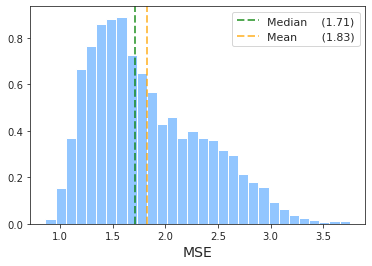

In [24]:
ax = eval_metrics['mse'].hist(bins=30, density=True, figsize=(6,4));

summary = eval_metrics['mse'].describe(percentiles=[]).round(2)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("MSE", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

#### Bias Distributions

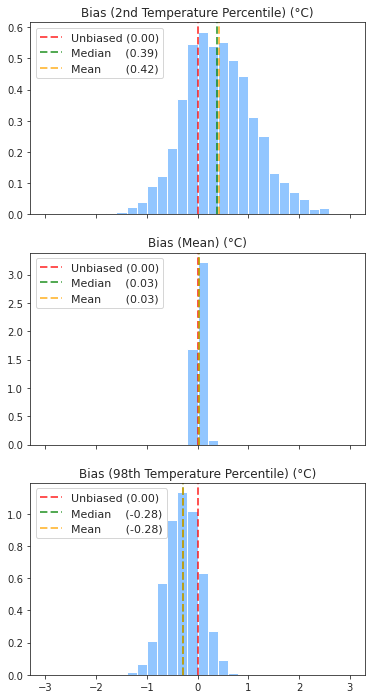

In [25]:
fig, axes =  plt.subplots(3, 1, figsize=(6,12), sharex=True)

measure_and_column = zip(
    [f"Bias ({loc}) (°C)" for loc in ["2nd Temperature Percentile", "Mean", "98th Temperature Percentile"]],
    ['bias_p02', 'bias_mean', 'bias_p98']
)

for i, (measure, col) in enumerate(measure_and_column):
    axes[i].hist(eval_metrics[col], range=(-3,3), bins=30, density=True, label=None)

    # summary statistics
    summary = eval_metrics[col].describe(percentiles=[]).round(2)
    axes[i].axvline(0, color="red", label="Unbiased (0.00)", **shared_line_kwargs)
    axes[i].axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
    axes[i].axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

    # labels
    axes[i].set_title(measure)
    axes[i].legend(loc="upper left", fontsize=11)

### Stability Distribution

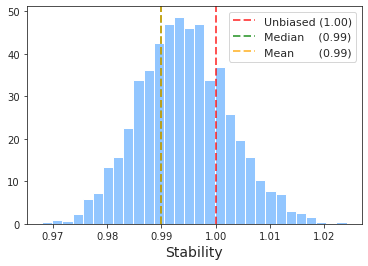

In [26]:
ax = eval_metrics['stability'].hist(bins=30, density=True, figsize=(6,4));

summary = eval_metrics['stability'].describe(percentiles=[]).round(2)
ax.axvline(1, color="red", label="Unbiased (1.00)", **shared_line_kwargs)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("Stability", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

### Errors by Geography

In [27]:
abs_error = (preds_validation - fine_validation)

In [28]:
latitudes = data_module.fine.index.levels[1].to_series()
longitudes = data_module.fine.index.levels[2].to_series()

In [29]:
from mpl_toolkits.basemap import Basemap, cm

In [30]:
m = Basemap(projection='ortho', lat_0=30 ,lon_0=-100, resolution='l')
x, y = m(*np.meshgrid(longitudes-180,latitudes))

#### Random Average Day

In [31]:
random_average_day = eval_metrics[eval_metrics['mse'].between(1.5,2)].index.to_series().sample(1, random_state=1729).iloc[0]

index_in_val = val_dates.get_loc(random_average_day)

eval_metrics.loc[random_average_day]

mse          1.534719
corr         0.994895
bias_p02    -0.063440
bias_mean   -0.033041
bias_p98    -0.907557
stability    0.985743
Name: 2011-05-26 00:00:00, dtype: float32

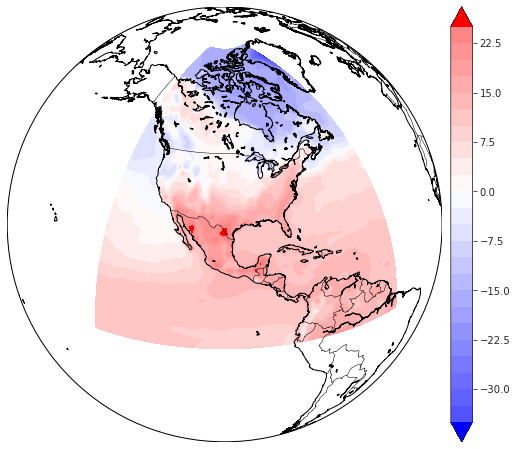

In [32]:
cs = m.contourf(
    x, y,
    fine_validation[index_in_val,...],
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

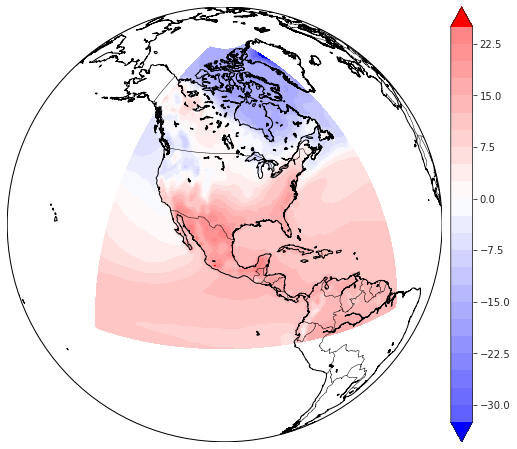

In [33]:
cs = m.contourf(
    x, y,
    preds_validation[index_in_val,...],
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

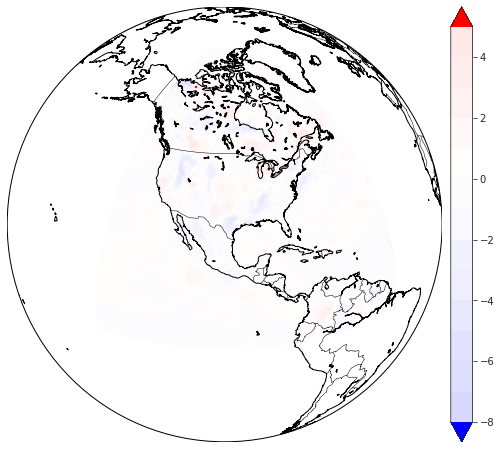

In [34]:
cs = m.contourf(
    x, y,
    abs_error[index_in_val,...],
    levels=16, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

#### Poor-Performing Day

In [35]:
random_bad_day = eval_metrics[eval_metrics['mse'].between(3,3.5)].index.to_series().sample(1, random_state=1729).iloc[0]

index_in_val = val_dates.get_loc(random_bad_day)

eval_metrics.loc[random_bad_day]

mse          3.162660
corr         0.996680
bias_p02     2.402092
bias_mean    0.091243
bias_p98    -0.966814
stability    0.987539
Name: 2011-02-26 00:00:00, dtype: float32

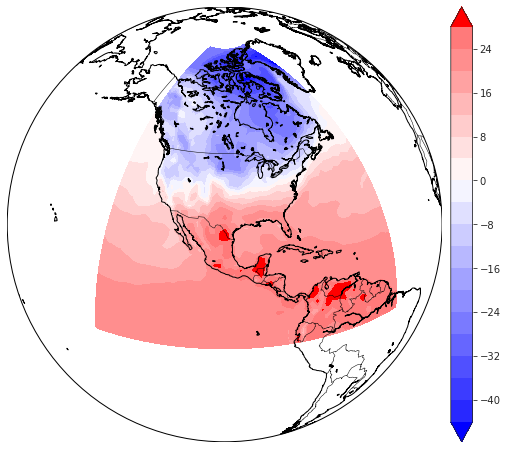

In [36]:
cs = m.contourf(
    x, y,
    fine_validation[index_in_val,...],
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

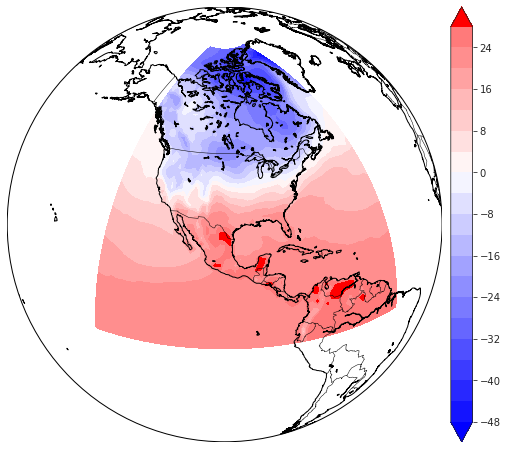

In [37]:
cs = m.contourf(
    x, y,
    preds_validation[index_in_val,...],
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

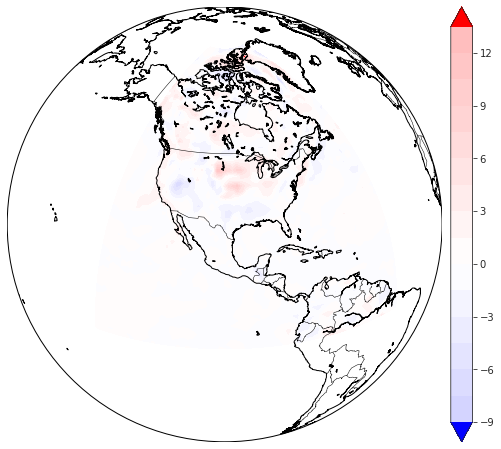

In [38]:
cs = m.contourf(
    x, y,
    abs_error[index_in_val,...],
    levels=16, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();